<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Qiskit Aer: Applying noise to custom gates

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

## Introduction

This notebook shows how to use some experimental noise features to define a noise model for any unitary gate, not just the ones supported by the backend.

**Disclaimer:** This is considered *experimental* as it involves modifying a compiled Qobj since the featurs are not yet supported through the Qiskit Terra `QuantumCircuit` API. As such they may change or break in future releases. Qiskit Aer includes some tools to help do this in the `qiskit_aer.utils.qobj_utils` module

In [1]:
import numpy as np

# Import Qiskit
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import amplitude_damping_error
from qiskit import compile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info.operators.unitary import Unitary
from qiskit.transpiler import transpile
from qiskit.compiler import assemble_circuits

## Simulating a custom unitary gate

The Qiskit Aer simulators support defining a custom unitary matrix as

```
Unitary(matrix, *qubits, label=label)
```

Where `matrix` is the unitary matrix we wish to apply, `qubits` is the list of QuantumRegister elements the matrix acts on, and `label` is an optional label string we can later use to identify this matrix in a noise model.

For example we can make a `Unitary` for a Controlled-NOT gate with qubit-0 as control, and qubit-1 as target as follows:

In [2]:
qr = QuantumRegister(2)
cx_mat = np.array([[1, 0, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0]])
custom_cx = Unitary(cx_mat, qr[0], qr[1], label='custom_cx')

**Note:** The matrix is specified with respect to the tensor product $U_{b}\otimes U_{a}$ for `qubits=[a, b]`.

## Example: using the iSWAP gate to implement a CX gate

Lets consider an explicit example of using the unitary instruction for a custom gate. We will use the iSWAP gate which is an entangling two-qubit gate given by

$$\mbox{iSWAP} = \left(\begin{array} 
& 1 & 0 & 0 & 0 \\ 
0 & 0 & i & 0 \\ 
0 & i & 0 & 0 \\ 
0 & 0 & 0 & 1
\end{array}\right)$$

A CX gate can be implemented using two iSWAP gates and single qubit gates with the following circuit:

FIGURE TODO

The Unitary gate can be added to a quantum circuit directly:

In [3]:
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(2, 'cr')
cx_circ = QuantumCircuit(qr, cr, name='cx')
iswap_mat = np.array([[1, 0, 0, 0],
                      [0, 0, 1j, 0],
                      [0, 1j, 0, 0],
                      [0, 0, 0, 1]])

iswap01 = Unitary(iswap_mat, qr[0], qr[1], label='iswap')

# CNOT Circuit where iSWAP gates should be inserted at barrier locations
cx_circ.sdg(qr[1])
cx_circ.h(qr[1])
cx_circ.sdg(qr[0])
cx_circ += iswap01
cx_circ.sdg(qr[0])
cx_circ.h(qr[0])
cx_circ.sdg(qr[0])
cx_circ += iswap01
cx_circ.s(qr[1])
print(cx_circ)

         ┌─────┐     ┌──────────┐┌─────┐┌───┐┌─────┐┌──────────┐     
qr_0: |0>┤ Sdg ├─────┤0         ├┤ Sdg ├┤ H ├┤ Sdg ├┤0         ├─────
         ├─────┤┌───┐│  unitary │└─────┘└───┘└─────┘│  unitary │┌───┐
qr_1: |0>┤ Sdg ├┤ H ├┤1         ├───────────────────┤1         ├┤ S ├
         └─────┘└───┘└──────────┘                   └──────────┘└───┘
 cr_0: 0 ════════════════════════════════════════════════════════════
                                                                     
 cr_1: 0 ════════════════════════════════════════════════════════════
                                                                     


### Verifying circuit on the Aer unitary simulator

We will execute the circuit on the Aer unitary simulator to verify our qobj implements the CX gate

In [4]:
# Select UnitarySimulator backend
simulator = Aer.get_backend('unitary_simulator')

# Compile the circuit qobj and insert iSWAP instructions
qobj = assemble_circuits(transpile(cx_circ, simulator))

# Execute on the simulator
result = simulator.run(qobj).result()
unitary = result.get_unitary(cx_circ)
print("Circuit unitary:")
print(unitary)

AttributeError: 'QobjConfig' object has no attribute 'shots'

So we have confirmed that our circuit implemented the correct unitary!

## Using a custom unitary in a noise model

Now that we have executed a qobj that includes a custom unitary instruction, we can now assign a quantum error to this gate in a `NoiseModel`. To do this we simply use our unitary instruction label `iswap` for the gate name when adding a quantum error to the noise model. For our example we will create an 2-qubit error consisting of two single-qubit amplitude damping channels with different damping parameters. For now we will assume all the other circuit instructions are ideal

In [4]:
# Error parameters
param_q0 = 0.05  # damping parameter for qubit-0
param_q1 = 0.1   # damping parameter for qubit-1
p_state1 = 0.03  # |1> state equilibrium population for damping

# Construct the error
qerror_q0 = amplitude_damping_error(param_q0, excited_state_population=p_state1)
qerror_q1 = amplitude_damping_error(param_q1, excited_state_population=p_state1)
iswap_error = qerror_q1.kron(qerror_q0)

# Build the noise model by adding the error to the "iswap" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(iswap_error, 'iswap')

Let us first take our previous CX circuit and add an initial Hadamard gate and final measurement to create a Bell-state preparation circuit that we may simulator on the `QasmSimulator` both for the ideal and noisy case

In [5]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(qr, cr, name='bell')
bell_circ.h(qr[0])
bell_circ = bell_circ + cx_circ 
bell_circ.measure(qr, cr)
print("Bell preparation circuit: iSWAPS should be inserted at barrier positions")
print(bell_circ)

Bell preparation circuit: iSWAPS should be inserted at barrier positions
         ┌─────┐┌─────┐┌──────────┐┌─────┐┌───┐┌─────┐┌──────────┐┌─┐        
qr_0: |0>┤  H  ├┤ Sdg ├┤0         ├┤ Sdg ├┤ H ├┤ Sdg ├┤0         ├┤M├────────
         ├─────┤├─────┤│  unitary │└─────┘└───┘└─────┘│  unitary │└╥┘┌───┐┌─┐
qr_1: |0>┤ Sdg ├┤  H  ├┤1         ├───────────────────┤1         ├─╫─┤ S ├┤M├
         └─────┘└─────┘└──────────┘                   └──────────┘ ║ └───┘└╥┘
 cr_0: 0 ══════════════════════════════════════════════════════════╩═══════╬═
                                                                           ║ 
 cr_1: 0 ══════════════════════════════════════════════════════════════════╩═
                                                                             


Again we must add iSWAP gates back into the compiled qobj for execution on the Aer Qasm simulator

In [9]:
# Select UnitarySimulator backend
simulator = Aer.get_backend('qasm_simulator')

# Compile the circuit qobj and insert iSWAP instructions
qobj = assemble_circuits(transpile(bell_circ, simulator))

NameError: name 'assemble_circuits' is not defined

### Ideal output

Lets first see the ideal output. Since this generates a Bell-state we expect two peaks for 00 and 11

In [7]:
# Execute on the simulator without noise
result = simulator.run(qobj).result()
ideal_counts = result.get_counts(bell_circ)
plot_histogram(ideal_counts, title='Ideal output for iSWAP bell-state preparation')

Process Process-1:
Traceback (most recent call last):
  File "/home/erick/apps/miniconda3/envs/qiskit/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/erick/apps/miniconda3/envs/qiskit/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/erick/apps/miniconda3/envs/qiskit/lib/python3.6/concurrent/futures/process.py", line 169, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/erick/apps/miniconda3/envs/qiskit/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/erick/software/qiskit-terra/qiskit/validation/base.py", line 296, in _base_model_from_kwargs
    return cls(**kwargs)
  File "/home/erick/software/qiskit-terra/qiskit/validation/base.py", line 245, in _decorated
    ex.messages, ex.field_names, ex.fields, ex.data, **ex.kwargs) from None
qiskit.validation.exceptions.ModelValidationError:

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

### Noisy circuit execution

Finally lets now simulate it with our custom noise model. Since there is a small amplitude damping error on the two qubit gates we expect small additional peaks for the 01 and 10 outcome probabilities

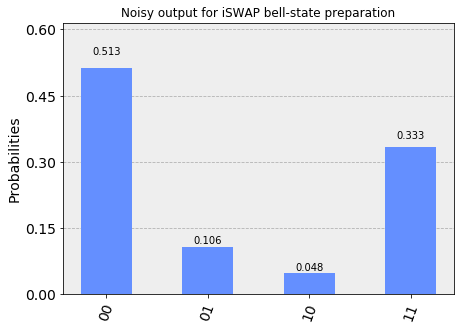

In [11]:
# Execute on the simulator without noise
result = simulator.run(qobj, noise_model=noise_model).result()
noise_counts = result.get_counts(bell_circ)
plot_histogram(noise_counts, title='Noisy output for iSWAP bell-state preparation')